# Домашняя работа №5.

* Написать модель (с помощью выдвижения гипотез или применяя модель Random Forest) на датасет больных сердечными болезнями (можно почистить от выбросов).

In [2]:
# Turn off code warnings (this is not recommended for routine use)
import warnings
warnings.filterwarnings("ignore")


import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import pearsonr
import ssl
# следующая строчка подключает сертификат для защищенного соединения
ssl._create_default_https_context = ssl._create_unverified_context
%matplotlib inline

import scipy.stats as st
import statsmodels as sm
import matplotlib
import io
import requests
import seaborn as sns
from sklearn.metrics import classification_report



In [ ]:
Data description
There are 3 types of input features:

Objective: factual information;
Examination: results of medical examination;
Subjective: information given by the patient.
Features:

Age | Objective Feature | age | int (days)
Height | Objective Feature | height | int (cm) |
Weight | Objective Feature | weight | float (kg) |
Gender | Objective Feature | gender | categorical code |
Systolic blood pressure | Examination Feature | ap_hi | int |
Diastolic blood pressure | Examination Feature | ap_lo | int |
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
Smoking | Subjective Feature | smoke | binary |
Alcohol intake | Subjective Feature | alco | binary |
Physical activity | Subjective Feature | active | binary |
Presence or absence of cardiovascular disease | Target Variable | cardio | binary |
All of the dataset values were collected at the moment of medical examination.

In [3]:
url="http://yustiks.ru/dataset/cardio_train.csv"
data=pd.read_csv(url,sep=";")
data.tail()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1
69999,99999,20540,1,170,72.0,120,80,2,1,0,0,1,0


Данный датасет разобран в начале лекции 5.

Модель Random Forest при обучении дает такой метод как feature importances, используя его, можно оценить какой параметр **максимально** влияет на болезнь.

* Сделать вывод о том, какой атрибут оказывает значительное влияние на наличие или отсутствие болезни.

Основная задача: определить, что влияет на сердечную болезнь больше всего. Например, выдвигая гипотезу о том, что тот кто курит, болеет чаще, мы сравниваем курящих пациентов с некурящими, и определяя насколько статистически значимы выборки, делаем вывод, что одна выборка статистически отличима от другой (или неотличима)

Есть ли отсутствующие значения?

In [4]:
data.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [5]:
df = data.iloc[:,3:7]
df[:4]

,height,weight,ap_hi,ap_lo
0,168,62.0,110,80
1,156,85.0,140,90
2,165,64.0,130,70
3,169,82.0,150,100


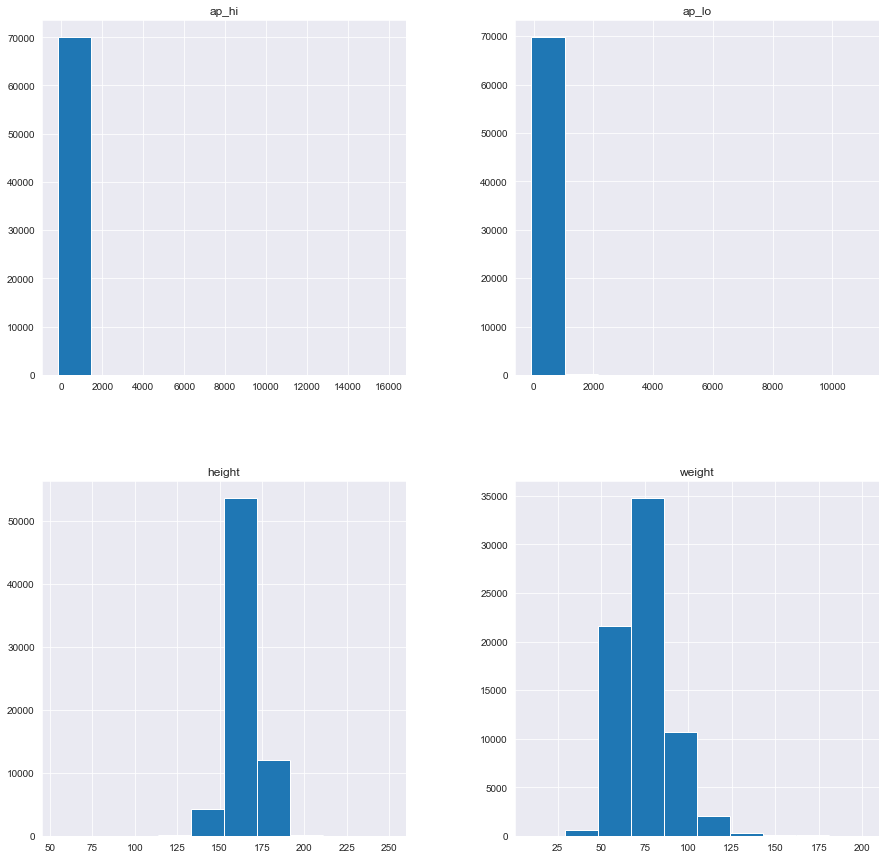

In [6]:
df.hist(figsize=(15,15))
plt.show()

In [7]:
headers = list(df.columns.values)

In [8]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

np_scaled = min_max_scaler.fit_transform(df)
df_norm = pd.DataFrame(np_scaled)
df_norm.head()

,0,1,2,3
0,0.158974,-0.452632,-0.967842,-0.972900
1,0.035897,-0.210526,-0.964131,-0.971093
2,0.128205,-0.431579,-0.965368,-0.974706
3,0.169231,-0.242105,-0.962894,-0.969286
4,0.035897,-0.515789,-0.969079,-0.976513


In [9]:
df_norm.columns = headers
df_norm.head()

,height,weight,ap_hi,ap_lo
0,0.158974,-0.452632,-0.967842,-0.972900
1,0.035897,-0.210526,-0.964131,-0.971093
2,0.128205,-0.431579,-0.965368,-0.974706
3,0.169231,-0.242105,-0.962894,-0.969286
4,0.035897,-0.515789,-0.969079,-0.976513


In [10]:
len(df_norm)

70000

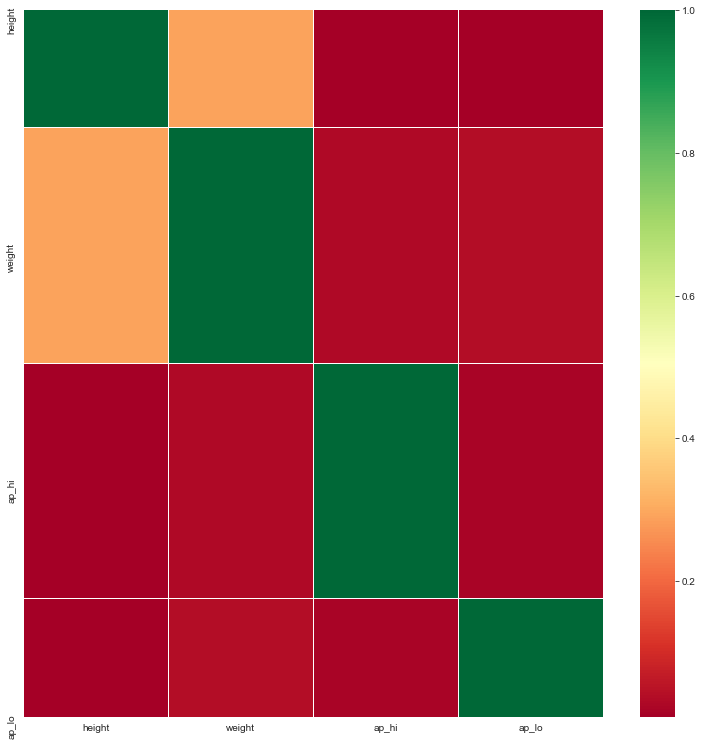

In [11]:
f, ax = plt.subplots(figsize=(13, 13))
corr = np.round_(df_norm.corr(), decimals=2)
sns.heatmap(corr,annot=False,cmap='RdYlGn',linewidths=0.2)

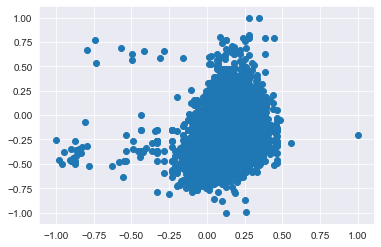

In [12]:
plt.scatter(df_norm['height'], df_norm['weight'])
plt.show()

Проверим на наличие выбросов.

In [13]:
from pylab import *

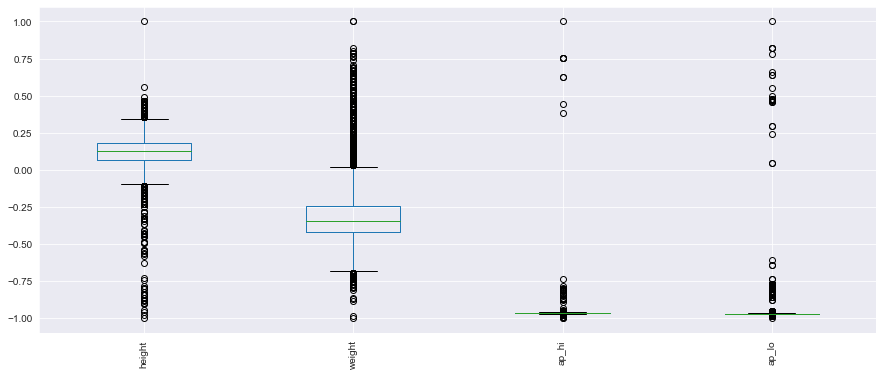

In [14]:
boxplot = df_norm.boxplot(figsize=(15,6), rot=90)

In [15]:
low = .05
high = .95
quant_df = df_norm.quantile([low, high])

In [16]:
filt_df = df_norm.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
                                    (x < quant_df.loc[high,x.name])], axis=0)

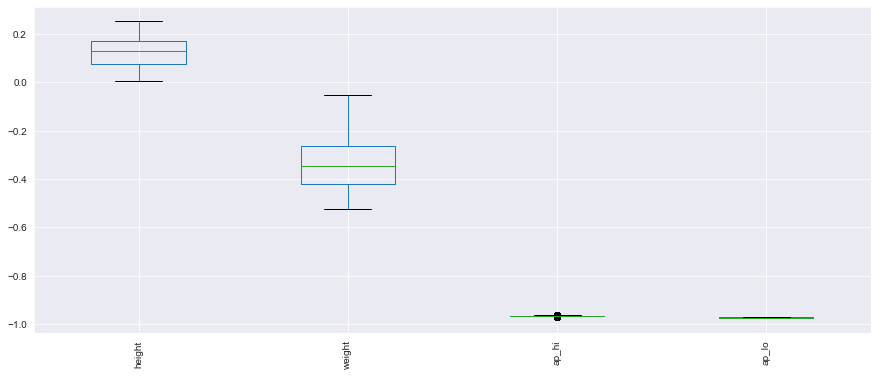

In [17]:
boxplot = filt_df.boxplot(figsize=(15,6), rot=90)

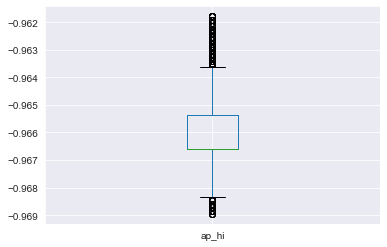

In [18]:
filt_df['ap_hi'].plot(kind='box')

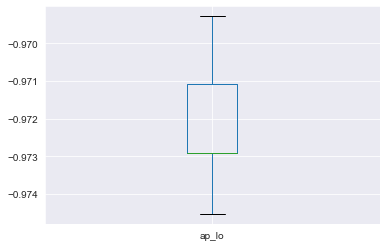

In [19]:
filt_df['ap_lo'].plot(kind='box')

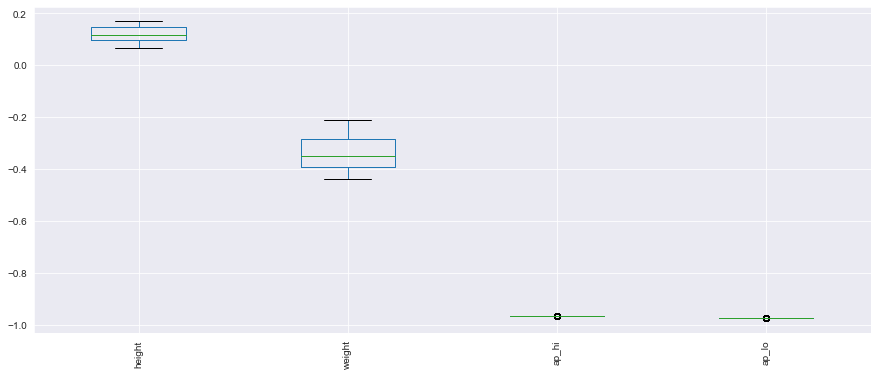

In [20]:
low = .2
high = .8
quant_df = df_norm.quantile([low, high])
filt_df_2 = df_norm.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
                                    (x < quant_df.loc[high,x.name])], axis=0)
boxplot = filt_df_2.boxplot(figsize=(15,6), rot=90)

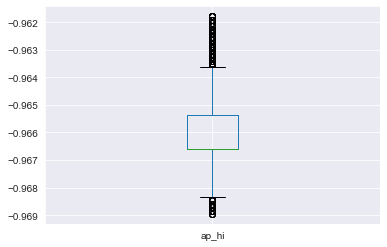

In [21]:
filt_df['ap_hi'].plot(kind='box')

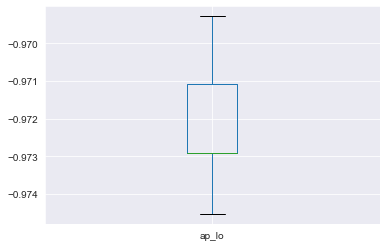

In [22]:
filt_df['ap_lo'].plot(kind='box')

In [23]:
filt_df.tail()

,height,weight,ap_hi,ap_lo
69995,0.158974,-0.305263,-0.966605,-0.972900
69996,0.056410,NaN,-0.964131,-0.971093
69997,NaN,NaN,NaN,-0.971093
69998,0.107692,-0.347368,-0.964750,-0.972900
69999,0.179487,-0.347368,-0.966605,-0.972900


In [24]:
filt_df.isnull().sum()

height     8111
weight     7739
ap_hi      8681
ap_lo     14924
dtype: int64

In [25]:
df2 = filt_df.dropna()

In [26]:
df2.isnull().sum()

height    0
weight    0
ap_hi     0
ap_lo     0
dtype: int64

In [27]:
len(df2)

40663

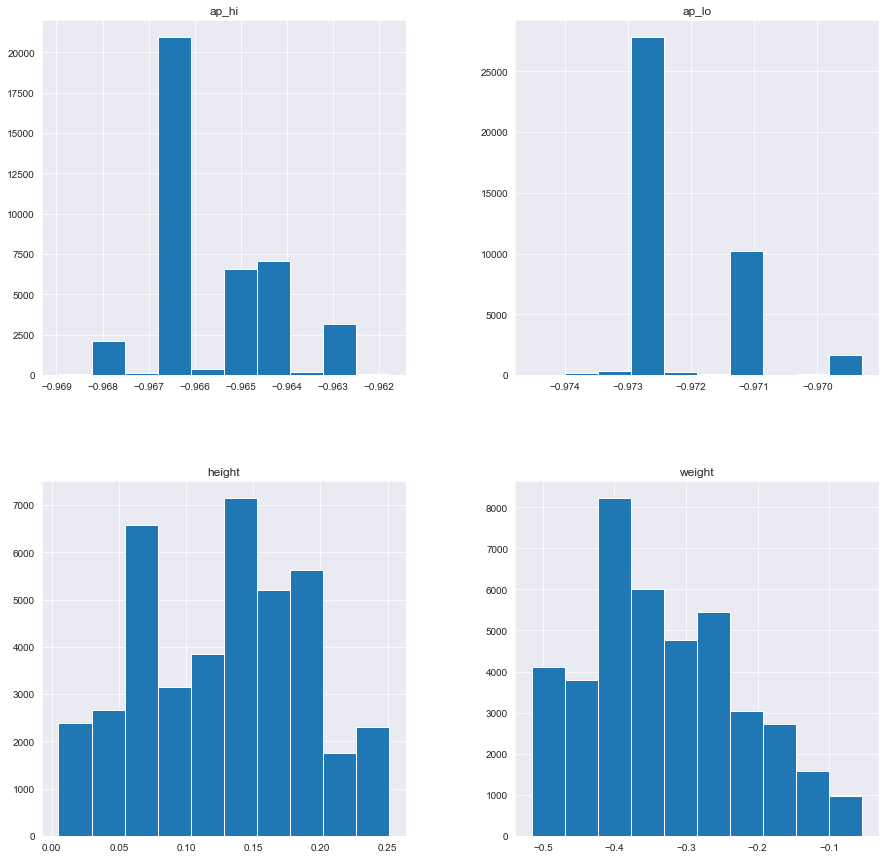

In [28]:
df2.hist(figsize=(15,15))
plt.show()

Таким образом мы нормализовали атрибуты, почистили выбросы по уровня 5 и 95. Также убрали появившиеся nan значения.
Длина датасета уменьшилась с 70000 на 40663 элементов.

# Модель деревья решений (Random Forest) для классификационной задачи

In [29]:
headata = list(data.columns.values)

In [30]:
headata

['id',
 'age',
 'gender',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'cholesterol',
 'gluc',
 'smoke',
 'alco',
 'active',
 'cardio']

In [52]:
output_y = data[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']]
#input_x = dataset_temp.iloc[:,:27]
input_x = df2

In [53]:
output_y

,gender,cholesterol,gluc,smoke,alco,active,cardio
0,2,1,1,0,0,1,0
1,1,3,1,0,0,1,1
2,1,3,1,0,0,0,1
3,2,1,1,0,0,1,1
4,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...
69995,2,1,1,1,0,1,0
69996,1,2,2,0,0,1,1
69997,2,3,1,0,1,0,1
69998,1,1,2,0,0,0,1


In [54]:
input_x

,height,weight,ap_hi,ap_lo
0,0.158974,-0.452632,-0.967842,-0.972900
1,0.035897,-0.210526,-0.964131,-0.971093
3,0.169231,-0.242105,-0.962894,-0.969286
6,0.046154,-0.126316,-0.965368,-0.972900
10,0.169231,-0.263158,-0.966605,-0.972900
...,...,...,...,...
69993,0.200000,-0.368421,-0.965368,-0.971093
69994,0.128205,-0.263158,-0.962894,-0.972900
69995,0.158974,-0.305263,-0.966605,-0.972900
69998,0.107692,-0.347368,-0.964750,-0.972900


Перед тем как продолжить, уравняем число столбиков, с сохранением индексов.
Надо модифицировать output_y

In [55]:
yx_pd = pd.merge(output_y.reset_index(),input_x.reset_index(),on='index') #.reset_index()

In [44]:
yx_pd

,index,gender,cholesterol,gluc,smoke,alco,active,cardio,height,weight,ap_hi,ap_lo
0,0,2,1,1,0,0,1,0,0.158974,-0.452632,-0.967842,-0.972900
1,1,1,3,1,0,0,1,1,0.035897,-0.210526,-0.964131,-0.971093
2,3,2,1,1,0,0,1,1,0.169231,-0.242105,-0.962894,-0.969286
3,6,1,3,1,0,0,1,0,0.046154,-0.126316,-0.965368,-0.972900
4,10,1,1,1,0,0,1,0,0.169231,-0.263158,-0.966605,-0.972900
...,...,...,...,...,...,...,...,...,...,...,...,...
40658,69993,1,1,1,0,0,1,1,0.200000,-0.368421,-0.965368,-0.971093
40659,69994,1,1,1,0,0,1,1,0.128205,-0.263158,-0.962894,-0.972900
40660,69995,2,1,1,1,0,1,0,0.158974,-0.305263,-0.966605,-0.972900
40661,69998,1,1,2,0,0,0,1,0.107692,-0.347368,-0.964750,-0.972900


In [56]:
out_y = yx_pd.iloc[:,1:8]
out_y

,gender,cholesterol,gluc,smoke,alco,active,cardio
0,2,1,1,0,0,1,0
1,1,3,1,0,0,1,1
2,2,1,1,0,0,1,1
3,1,3,1,0,0,1,0
4,1,1,1,0,0,1,0
...,...,...,...,...,...,...,...
40658,1,1,1,0,0,1,1
40659,1,1,1,0,0,1,1
40660,2,1,1,1,0,1,0
40661,1,1,2,0,0,0,1


In [58]:
inp_x = yx_pd.iloc[:,-4:]
inp_x

,height,weight,ap_hi,ap_lo
0,0.158974,-0.452632,-0.967842,-0.972900
1,0.035897,-0.210526,-0.964131,-0.971093
2,0.169231,-0.242105,-0.962894,-0.969286
3,0.046154,-0.126316,-0.965368,-0.972900
4,0.169231,-0.263158,-0.966605,-0.972900
...,...,...,...,...
40658,0.200000,-0.368421,-0.965368,-0.971093
40659,0.128205,-0.263158,-0.962894,-0.972900
40660,0.158974,-0.305263,-0.966605,-0.972900
40661,0.107692,-0.347368,-0.964750,-0.972900


In [62]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
targets=(out_y.iloc[:,:]==1).idxmax(1)
print(targets.value_counts())
Y=le.fit_transform(targets)

gender         26350
cholesterol    11272
gluc            1971
active           689
smoke            223
cardio            98
alco              60
dtype: int64


In [60]:
print(Y)

[3 4 4 ... 5 4 4]


In [63]:
from sklearn.model_selection import train_test_split
X_train_22, X_test_22, y_train_22, y_test_22 = train_test_split(inp_x, Y, test_size=0.3)

In [64]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train_22,y_train_22)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Наиболее важные атрибуты для модели Random Forest:

No handles with labels found to put in legend.


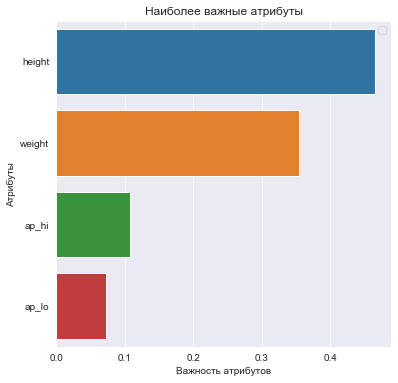

In [65]:
headers = list(X_train_22.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

Посчитаем качество модели - **classification report**:

In [66]:
model_pred = model.predict(X_test_22)

print(classification_report(y_test_22, model_pred))

model.score(X_test_22, y_test_22)

              precision    recall  f1-score   support

           0       0.04      0.01      0.02       183
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        28
           3       0.49      0.40      0.44      3386
           4       0.74      0.86      0.80      7924
           5       0.14      0.06      0.09       602
           6       0.00      0.00      0.00        56

    accuracy                           0.67     12199
   macro avg       0.20      0.19      0.19     12199
weighted avg       0.63      0.67      0.64     12199



0.668661365685712

Модель "рандомных деревьев" дала точность предсказания порядка 67%.

Наибольшее влияние на наличие болезни влияет рост человека.
И для классов smoke и alco чувствительность и точность метода приемлимы.  

Лучшие точностные показателя будут для высоких пьющих людей.

In [70]:
import researchpy as rp

Работаем по yx_pd (сводной таблице с одинаковыми элементами)

# Проверим гипотезу о том, что люди, которые курят, болеют чаще сердечной болезнью (на этот раз почистили некоторые переменные, удалили выбросы)

In [71]:
smoke = yx_pd[yx_pd['smoke']==1].cardio
no_smoke = yx_pd[yx_pd['smoke']==0].cardio
descriptives, results = rp.ttest(smoke, no_smoke)
print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio   3384.0  0.479610  0.499658  0.008589   0.462769  0.496451
1    cardio  37279.0  0.519032  0.499644  0.002588   0.513960  0.524104
2  combined  40663.0  0.515751  0.499758  0.002478   0.510894  0.520609
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.0394
1            Degrees of freedom =   40661.0000
2                             t =      -4.3947
3         Two side test p value =       0.0000
4        Difference < 0 p value =       0.0000
5        Difference > 0 p value =       1.0000
6                     Cohen's d =      -0.0789
7                     Hedge's g =      -0.0789
8                 Glass's delta =      -0.0789
9                             r =       0.0218


Уменьшили выборку, удалив выбросы. Результаты, как на лекции по среднему значению. То есть уравняли количество элементов, результат тот же. Difference > 0 p value = 1.0000, значит, различие в двух выборках значительное.  Среднее значение по атрибуту cardio у курящих 0.47, среднее значение среди некурящих 0.52 (как на лекции примерно).

In [ ]:
# pd.concat([pin1, pin2]).sort_index()